# Reinforcement Learning: Parking-v0 Environment Demo

This notebook provides a preliminary demonstration of the `parking-v0` environment using the `highway-env` library. The goal is to set up and visualize how an agent interacts with the environment, paving the way for implementing a full reinforcement learning solution later.


# Envirionment setup

In [ ]:
!pip install highway_env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.0 MB/s eta 0:00:00


# Initialize the Environment

In [ ]:
import gymnasium as gym
import highway_env

env = gym.make('parking-v0', render_mode='rgb_array')

In [ ]:
# Helper function to display the episodes
import imageio
from base64 import b64encode
from IPython.display import HTML
import tempfile

def display_frames(frames, fps=30, width=640):
    """
    Converts a list of RGB frames into a video and displays it inline (Colab/Jupyter).

    Parameters:
        frames (list): List of RGB arrays
        fps (int): Frames per second
        width (int): Display width in pixels

    Returns:
        IPython HTML video object
    """


    # Save to a temporary video file
    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as f:
        imageio.mimsave(f.name, frames, fps=fps)
        video_path = f.name

    # Encode video for display
    with open(video_path, "rb") as f:
        video_data = f.read()
    encoded = b64encode(video_data).decode("utf-8")

    return HTML(f"""
    <video width="{width}" controls>
        <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
    </video>
    """)

Runs a sample episode where actions are hardcoded (here: [0.5, 0.9]), not learned. This part does not use an RL policy, but simply demonstrates how the environment reacts to fixed or random actions.

In [ ]:
obs, info = env.reset()
done = truncated = False
frames = []
while not (done or truncated):
    action = env.action_space.sample()
    action = [0.5,0.9]
    obs, reward, done, truncated, info = env.step(action)
    frames.append(env.render())
env.close()
display_frames(frames)

# Lets start with Deep-RL

In this section we will cover:

1. **REINFORCE (Vanilla Policy Gradient)**  
   A simple policy-based algorithm that updates the policy using the total return from each episode. It's a good baseline for understanding how learning progresses without complex tricks.

2. **Soft Actor-Critic (SAC)**  
   A modern off-policy algorithm that incorporates entropy regularization to encourage exploration and stability. SAC learns both a policy and a value function, making it more sample-efficient than REINFORCE.

While REINFORCE provides conceptual clarity, SAC offer practical performance improvements.

> 💡 **Tip**: REINFORCE is an *on-policy* algorithm—it learns only from actions it just took. SAC and HER are *off-policy*—they can learn from past experience and even improve using data collected in a different way. This makes them more flexible and efficient for environments like `parking-v0`.

## REINFORCE: Policy Gradient Method


In this algorithm, we use a neural network to directly **learn a policy**—a mapping from environment states to a distribution over possible actions.

The input to the network is the **state of the environment**, and the output is a **probability distribution** over actions, typically computed using a **softmax** activation in the final layer.

This distribution tells the agent how likely it is to take each possible action from a given state.

The figure below illustrates this architecture:
- 🟢 **Input**: Environment state (e.g., position, velocity, orientation).
- 🧠 **Network**: A fully connected neural network processes the state.
- 🎯 **Output**: A probability (softmax) over the discrete actions available.

> 📌 The REINFORCE algorithm collects full episodes using this policy, then adjusts the network weights to increase the probability of actions that led to high rewards. It’s a simple but foundational method in deep reinforcement learning.

Good explanation source: https://www.youtube.com/watch?v=5eSh5F8gjWU

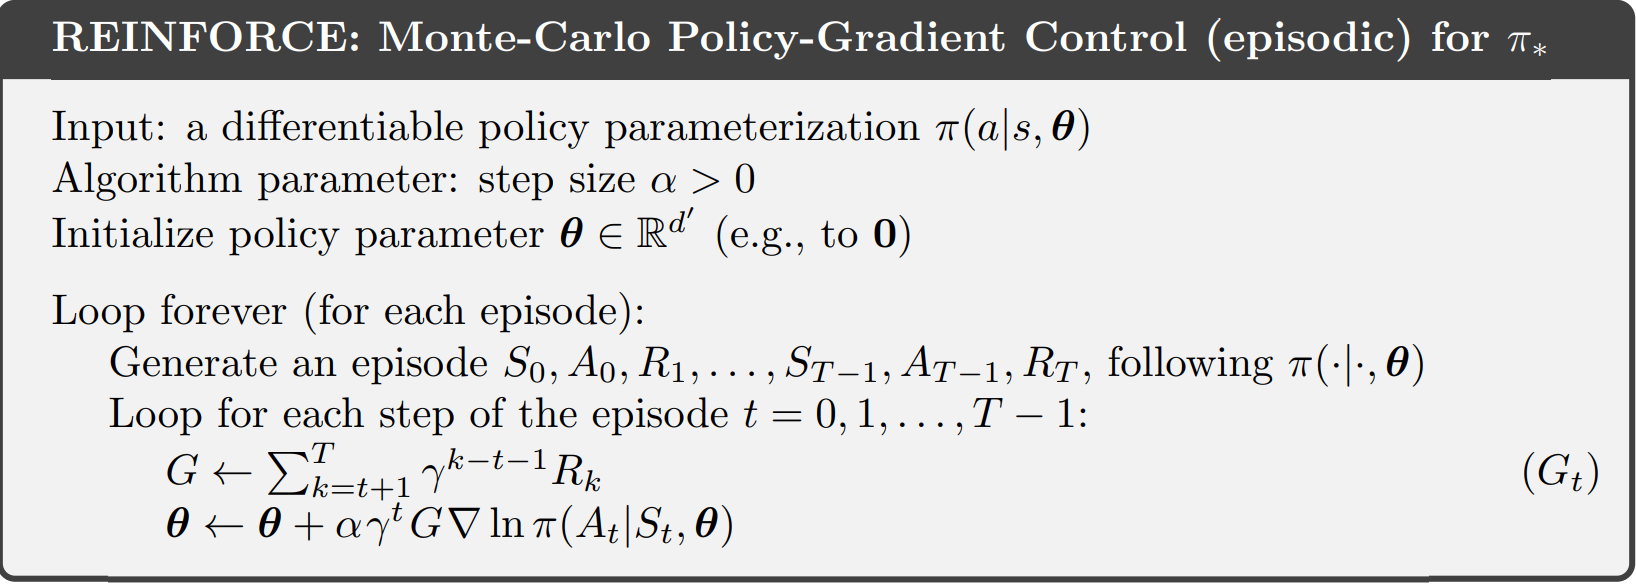

In environments with **continuous action spaces** (like `parking-v0`), we can't use a softmax distribution over discrete actions. Instead, we define a **parameterized probability distribution**—typically a **Gaussian (Normal) distribution**—from which actions are sampled.

In this implementation, our policy network outputs:
- 📈 A **mean vector** for the action distribution
- 🔒 A **log standard deviation**, ensuring positivity and numerical stability

The agent samples actions from this normal distribution:
- `action ~ N(mean, std)`
- It also computes the **log-probability of the action**, which is needed for the REINFORCE gradient update.

This setup allows REINFORCE to operate in continuous control tasks.

> 📚 **Reference**: For more intuition and math, see [this StackExchange post](https://math.stackexchange.com/questions/3179912/policy-gradient-reinforcement-learning-for-continuous-state-and-action-space)

Below is the implementation of the policy network used for this continuous REINFORCE variant.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

# To understand read:
# More in: https://math.stackexchange.com/questions/3179912/policy-gradient-reinforcement-learning-for-continuous-state-and-action-space
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)

        # The mean layer is the mean of the distribution
        self.mean_layer = nn.Linear(32, action_dim)
        # Compute the std, the log ensure that the std is positive and more stable
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        mean = self.mean_layer(x)
        std = torch.exp(self.log_std)
        return mean, std

    def sample_action(self, state):
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        action = dist.rsample()  # Enables gradients
        log_prob = dist.log_prob(action).sum()
        return action, log_prob

Episode 1: reward = -23.73, loss = -9.4060
Episode 11: reward = -36.68, loss = 5.1386
Episode 21: reward = -64.50, loss = -3.4968
Episode 31: reward = -17.57, loss = 4.3396
Episode 41: reward = -46.86, loss = 7.2769
Episode 51: reward = -31.74, loss = -3.1776
Episode 61: reward = -45.75, loss = 0.0591
Episode 71: reward = -24.69, loss = 8.3294
Episode 81: reward = -47.58, loss = -1.4185
Episode 91: reward = -17.91, loss = -3.2368
Episode 101: reward = -40.31, loss = 11.9070
Episode 111: reward = -42.80, loss = -9.1038
Episode 121: reward = -56.22, loss = -5.3931
Episode 131: reward = -43.40, loss = -2.5802
Episode 141: reward = -41.28, loss = 2.5265
Episode 151: reward = -20.69, loss = 1.9577
Episode 161: reward = -7.62, loss = 3.9020
Episode 171: reward = -60.98, loss = -11.2293
Episode 181: reward = -52.66, loss = -3.2866
Episode 191: reward = -44.45, loss = -8.9997
Episode 201: reward = -53.44, loss = 0.3796
Episode 211: reward = -70.68, loss = 19.9742
Episode 221: reward = -21.25, 

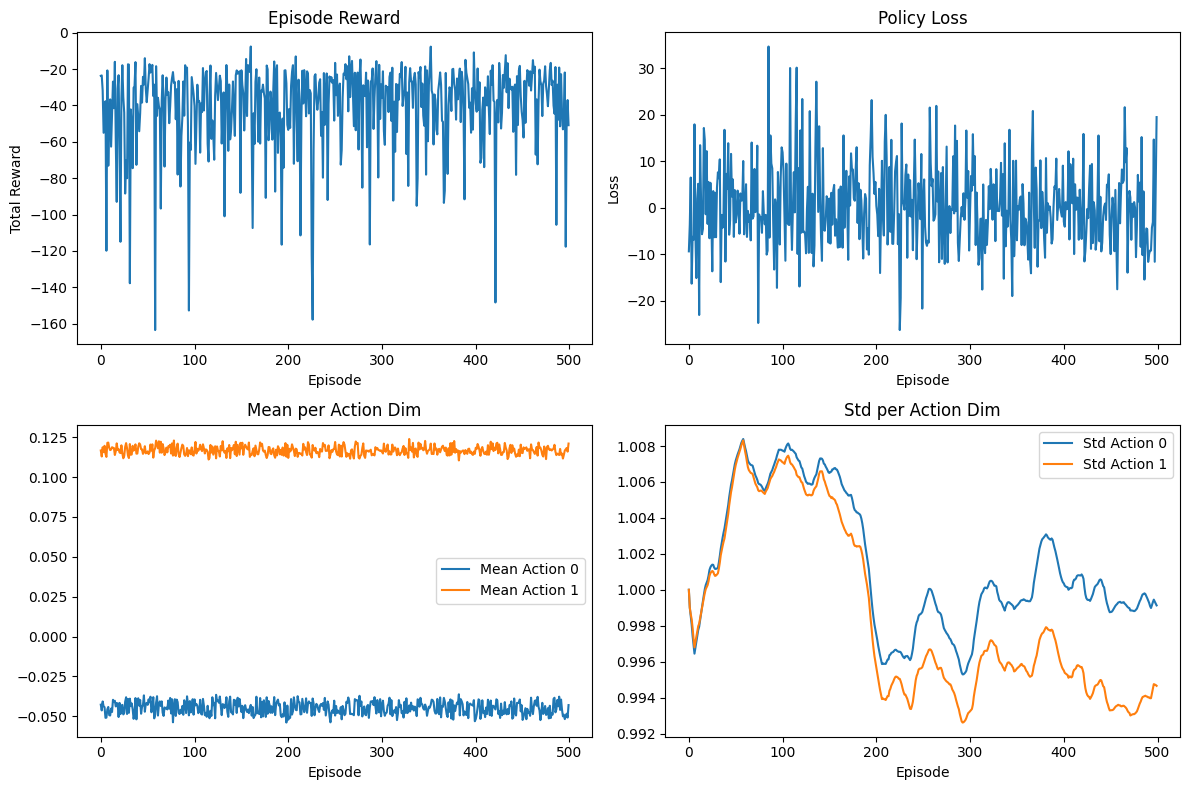

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# === Environment Setup ===
obs, info = env.reset()
obs = torch.cat([torch.tensor(obs[key], dtype=torch.float32) for key in obs])
obs_dim = len(obs)
action_dim = env.action_space.shape[0]

policy = PolicyNetwork(obs_dim, action_dim)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
gamma = 0.99
max_episodes = 500

# === Logging ===
reward_history = []
loss_history = []
mean_history = []
std_history = []

for episode in range(max_episodes):
    # === Reset environment and storage ===
    obs, info = env.reset()
    obs = torch.cat([torch.tensor(obs[key], dtype=torch.float32) for key in obs])
    done = truncated = False

    states = []
    actions = []
    log_probs = []
    rewards = []
    means = []
    stds = []

    while not (done or truncated):
        mean, std = policy.forward(obs)
        action_tensor, log_prob = policy.sample_action(obs)
        action = action_tensor.detach().cpu().numpy()
        if action.ndim == 0:
            action = np.expand_dims(action, axis=0)

        obs_, reward, done, truncated, info = env.step(action)

        # Store trajectory
        states.append(obs)
        actions.append(action_tensor)
        log_probs.append(log_prob)
        rewards.append(reward)
        means.append(mean.detach().cpu().numpy())
        stds.append(std.detach().cpu().numpy())

        obs = torch.cat([torch.tensor(obs_[key], dtype=torch.float32) for key in obs_])

    # === Compute discounted returns ===
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # === Policy Gradient Update ===
    policy_loss = [-log_prob * G for log_prob, G in zip(log_probs, returns)]
    loss = torch.stack(policy_loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # === Logging ===
    episode_reward = sum(rewards)
    reward_history.append(episode_reward)
    loss_history.append(loss.item())
    mean_history.append(np.mean(np.vstack(means), axis=0))
    std_history.append(np.mean(np.vstack(stds), axis=0))

    if episode % 10 == 0:
        print(f"Episode {episode+1}: reward = {episode_reward:.2f}, loss = {loss.item():.4f}")

env.close()

# === Plotting after training ===
mean_history = np.array(mean_history)
std_history = np.array(std_history)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(reward_history)
axs[0, 0].set_title("Episode Reward")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Total Reward")

axs[0, 1].plot(loss_history)
axs[0, 1].set_title("Policy Loss")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Loss")

axs[1, 0].plot(mean_history[:, 0], label='Mean Action 0')
axs[1, 0].plot(mean_history[:, 1], label='Mean Action 1')
axs[1, 0].legend()
axs[1, 0].set_title("Mean per Action Dim")
axs[1, 0].set_xlabel("Episode")

axs[1, 1].plot(std_history[:, 0], label='Std Action 0')
axs[1, 1].plot(std_history[:, 1], label='Std Action 1')
axs[1, 1].legend()
axs[1, 1].set_title("Std per Action Dim")
axs[1, 1].set_xlabel("Episode")

plt.tight_layout()
plt.show()

The agent's performance fluctuated significantly between episodes, and there was no clear trend of consistent improvement. This variability is expected, as REINFORCE relies on high-variance gradient estimates and does not incorporate techniques like baselines or replay buffers to stabilize updates. As a result, while the model occasionally discovered better actions, it struggled to retain and build upon them, highlighting the limitations of vanilla policy gradient methods in more complex continuous control tasks.

### Lets see one episode using the trained policy model

In [ ]:
import torch
import numpy as np

obs, info = env.reset()
obs = torch.cat([torch.tensor(obs[key], dtype=torch.float32) for key in obs])
done = truncated = False

frames = []
total_reward = 0

while not (done or truncated):
    with torch.no_grad():
        action_tensor, _ = policy.sample_action(obs)
    action = action_tensor.cpu().numpy()
    if action.ndim == 0:
        action = np.expand_dims(action, axis=0)

    obs_, reward, done, truncated, info = env.step(action)
    total_reward += reward
    frames.append(env.render())

    # Update observation
    obs = torch.cat([torch.tensor(obs_[key], dtype=torch.float32) for key in obs_])

env.close()
print(f"Total reward: {total_reward:.2f}")

display_frames(frames)

Total reward: -31.61


## Soft Actor-Critic (SAC)

In this section, we train an agent using the **Soft Actor-Critic (SAC)** algorithm, a state-of-the-art method for continuous control tasks.

SAC is an **off-policy** actor-critic algorithm that combines three key ideas:
1. It learns both a policy (actor) and value functions (critics).
2. It encourages exploration by maximizing not just reward, but also **entropy**—a measure of randomness in the policy. This helps the agent stay uncertain in areas it's not confident about, which improves long-term learning.
3. It reuses past experiences via a **replay buffer**, making it more sample-efficient than methods like REINFORCE.

In the implementation below, we use `Stable-Baselines3` to initialize and train a SAC agent. The `MultiInputPolicy` is used when the environment provides observations in a dictionary (as `parking-v0` does). We train the model for 50,000 time steps (about 2068 episodes) to observe how well SAC handles the parking task.

> 💡 **Tip**: In SAC (and other actor-critic methods), the **value function** estimates how good it is to be in a given state or to take a specific action. This helps the agent evaluate different behaviors without waiting for full episode returns. By using value estimates, SAC reduces the randomness in learning and updates the policy more reliably than methods like REINFORCE.


In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from stable_baselines3 import SAC

model = SAC("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=5e4)

Streaming output truncated to the last 5000 lines.
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 960      |
|    fps             | 46       |
|    time_elapsed    | 683      |
|    total_timesteps | 31688    |
| train/             |          |
|    actor_loss      | 9.56     |
|    critic_loss     | 0.0257   |
|    ent_coef        | 0.0144   |
|    ent_coef_loss   | -0.243   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31587    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -12      |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 964      |
|    fps             | 46       |
|    time_elapsed    | 685      |
|    total_timesteps | 31762    |
| train/             |          |
|    actor_loss      | 9.48     |
|    critic_loss     | 0.0426   |
|    ent_coef        | 0.0144  

The SAC agent showed some learning progress during training but struggled to achieve consistent success in the parking task. While the training remained stable, the agent's performance plateaued early, with only minor improvements toward the end. This suggests that although SAC is more sample-efficient than REINFORCE, it still requires more training time, fine-tuning, or additional strategies

Lets see one episode

In [ ]:
obs, info = env.reset()
done = False
truncated = False
total_reward = 0
frames = []

while not (done or truncated):
  action, _ = model.predict(obs, deterministic=True)  # Use deterministic policy for testing
  obs, reward, done, truncated, info = env.step(action)
  total_reward += reward

  frame = env.render()
  frames.append(frame)
env.close()
display_frames(frames)

## HER and SAC (In construction)

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3 import HerReplayBuffer

model = SAC(
    policy="MultiInputPolicy",
    env=env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",  # 'final', 'episode', 'future'
    ),
    verbose=1,
)

model.learn(total_timesteps=5e4)


Streaming output truncated to the last 5000 lines.
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 44       |
|    time_elapsed    | 546      |
|    total_timesteps | 24458    |
| train/             |          |
|    actor_loss      | 3.56     |
|    critic_loss     | 0.0212   |
|    ent_coef        | 0.00608  |
|    ent_coef_loss   | 0.399    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24357    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34       |
|    ep_rew_mean     | -15.4    |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 44       |
|    time_elapsed    | 549      |
|    total_timesteps | 24562    |
| train/             |          |
|    actor_loss      | 3.57     |
|    critic_loss     | 0.0324   |
|    ent_coef        | 0.00611 

In [ ]:
obs, info = env.reset()
done = False
truncated = False
total_reward = 0
frames = []

while not (done or truncated):
  action, _ = model.predict(obs, deterministic=True)  # Use deterministic policy for testing
  obs, reward, done, truncated, info = env.step(action)
  total_reward += reward

  frame = env.render()
  frames.append(frame)
env.close()
display_frames(frames)

In [ ]:
model.save("sac_her_model")


In [ ]:
env = gym.make("parking-v0", render_mode="rgb_array")
env.unwrapped.configure({
    "add_walls": False
})

obs, info = env.reset()
done = False
truncated = False
total_reward = 0
frames = []

while not (done or truncated):
  action, _ = model.predict(obs, deterministic=True)  # Use deterministic policy for testing
  obs, reward, done, truncated, info = env.step(action)
  total_reward += reward

  frame = env.render()
  frames.append(frame)
env.close()
display_frames(frames)

# Future work

To improve learning efficiency, we plan to explore **curriculum learning** [1], where the agent trains on easier tasks before progressing to harder ones. We also aim to fine-tune SAC hyperparameters to improve convergence, and to incorporate Hindsight Experience Replay (HER), which can significantly boost performance in goal-based environments with sparse rewards.

We also aim to incorporate **explainability techniques** to better understand the agent's decisions. Following the work in [0], tools like saliency maps and decision tree approximations can offer insights into the policy’s behavior.

**References:**

[0] Puiutta, E., & Veith, E. M. (2020). Explainable Reinforcement Learning: A Survey. In Proceedings of the 19th International Conference on Autonomous Agents and MultiAgent Systems (AAMAS). arXiv:2004.14502

[1] Narvekar, S., Peng, B., Leonetti, M., Sinapov, J., Taylor, M. E., & Stone, P. (2020). Curriculum Learning for Reinforcement Learning Domains: A Framework and Survey. Journal of Machine Learning Research, 21(181), 1–50. arXiv:2003.04960